# Predição do preço do Bitcoin com uma RNN

![](bitcoin.png)

Bitcoin é uma moeda digital do tipo criptomoeda descentralizada, e também um sistema econômico alternativo, apresentada em 2008 na lista de discussão The Cryptography Mailing por um programador, ou um grupo de programadores, de pseudônimo Satoshi Nakamoto; É considerada a primeira moeda digital mundial descentralizada, e tida como responsável pelo ressurgimento do sistema bancário livre.
https://pt.wikipedia.org/wiki/Bitcoin

![](bitcoinhist.png)

Série histórica do valor do bitcoin desde 14 Jan 2014
https://coinmarketcap.com/

Vamos utilizar a série histórica para treinar uma Rede Neural Recorrente com o objetivo de prever 1 mes do valor da moeda


### Roteiro

* Analisar o Dataset com a série histórica do preço do bitcoin
* Preparar o Dataset para utilização pela RNN
* Criar uma LSTM para previsão do preço do bitcoin
* Usar a nossa rede neural para prever 1 mês do valor da moeda

### Bibliotecas

In [1]:
# Geral
import math
import pandas as pd

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Visualizacao
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
py.init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
np.random.seed(42)

### Dataset - coinmarketcap

In [4]:
# https://coinmarketcap.com/
df = pd.read_csv(filepath_or_buffer="data_bitcoin.csv", index_col="Date")

In [5]:
df = df[906:-1] # Jul 2016 - Now
df.head(4)

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2016-07-01,672.220,691.204,665.851,674.000,2086.281579,1.414909e+06,678.196508
2016-07-02,674.670,703.950,674.670,702.310,1237.972848,8.545239e+05,690.260610
2016-07-03,703.950,703.960,644.650,655.840,1542.945346,1.042102e+06,675.397588
2016-07-04,656.331,684.730,645.000,675.001,1718.815203,1.152591e+06,670.573063


In [6]:
df.shape

(506, 7)

In [7]:
btc_trace = go.Scatter(x=df.index, y=df['Close'], name= 'Price')
py.iplot([btc_trace])

Iremos utilizar apenas as informações do **preço de fechamento da moeda no dia (df.Close)**. A intenção é prever esse valor usando apenas os dados históricos do mesmo valor.

### 1. Criação do dataset para treinamento/test 

O valor que pretendemos prever é o de **Fechamento do dia**

In [8]:
values = df.Close.values.reshape(-1,1)

Normalização dos dados por desvio padrão:

In [9]:
scaler        = StandardScaler()
scaled_values = scaler.fit_transform(values)

Separação dos dados de **treinamento** e de **teste**. Utilizaremos **1 meses** para teste e o resto para treinamento

In [10]:
train_size = len(scaled_values)-30
test_size  = len(scaled_values) - train_size

train, test = scaled_values[0:train_size,:], scaled_values[train_size:len(scaled_values),:]
print("Treinamento:", len(train))
print("Teste:", len(test))

Treinamento: 476
Teste: 30


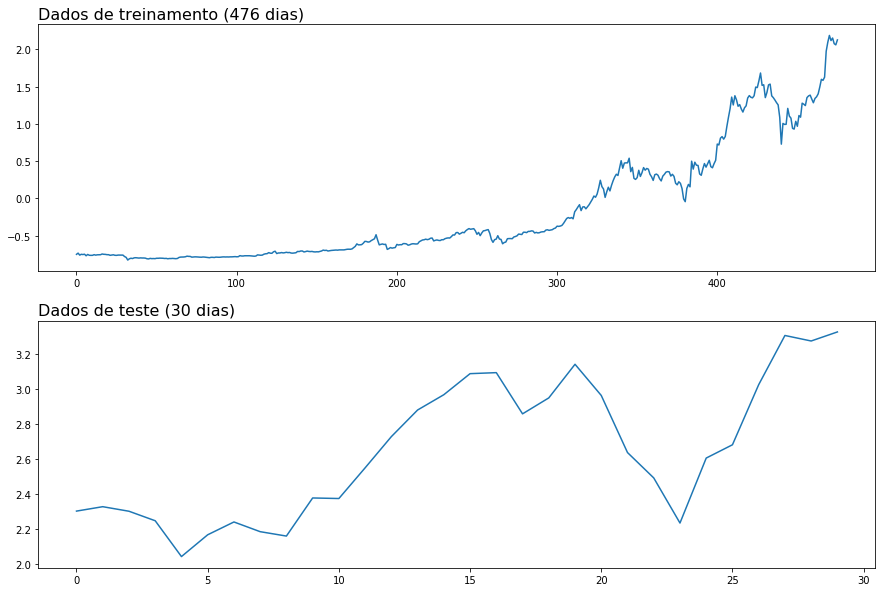

In [11]:
# Plot grafico treinamento e teste
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(211)
ax.set_title('Dados de treinamento ('+str(len(train))+' dias)', loc='left', fontsize=16)
plt.plot(train)

ax = plt.subplot(212)
ax.set_title('Dados de teste ('+str(len(test))+' dias)', loc='left', fontsize=16)
plt.plot(test)

Como é uma previsão de série histórica, precisamos criar o dataset que reflita a previsão. Ou seja, dado $$x(t-2), x(t-1), x(t)$$ devemos prever $$x(t+1)$$

![](img2.png)

In [12]:
# Monta o dadaset de X, Y com atraso 
def dataset_with_look_back(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
dataset = np.array([1, 2, 3, 4, 5]).reshape(-1,1)

datasetX, datasetY = dataset_with_look_back(dataset, 1)

print('dataset: ', list(dataset.reshape(1,-1)[0]))
print('datasetX: ',list(datasetX.reshape(1,-1)[0]))
print('datasetY: ',list(datasetY))

dataset:  [1, 2, 3, 4, 5]
datasetX:  [1, 2, 3, 4]
datasetY:  [2, 3, 4, 5]


Cria o valor de entrada (X) e o de saida (Y) para os dados de treinamento e test

In [14]:
# Janela de entrada para a rede
look_back = 5

trainX, trainY = dataset_with_look_back(train, look_back)
testX, testY   = dataset_with_look_back(test, look_back)
trainX.shape

(471, 5)

In [15]:
trainX

array([[-0.75176137, -0.73552146, -0.76217877, -0.75118715, -0.75450913],
       [-0.73552146, -0.76217877, -0.75118715, -0.75450913, -0.74998306],
       [-0.76217877, -0.75118715, -0.75450913, -0.74998306, -0.77103586],
       ..., 
       [ 1.97632541,  2.0969631 ,  2.18874641,  2.11990893,  2.15363929],
       [ 2.0969631 ,  2.18874641,  2.11990893,  2.15363929,  2.07774597],
       [ 2.18874641,  2.11990893,  2.15363929,  2.07774597,  2.06220017]])

A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica na forma de: ***[samples, time steps, features]***.

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX.shape

(471, 1, 5)

### 2. Criação do modelo de Rede Neural Recorrente com LSTM

In [25]:
model = Sequential()

model.add(LSTM(10, input_shape=(trainX.shape[1], trainX.shape[2]))) # 10 LSTM blocks
model.add(Dropout(0.1)) # 10% of dropout 
model.add(Dense(1)) # MLP FullyConnect
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                640       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________


#### Treinamento

In [ ]:
# Params
epochs     = 50
batch_size = 5

# Train
history = model.fit(trainX, trainY, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(testX, testY), 
                    shuffle=False)

Train on 471 samples, validate on 25 samples
Epoch 1/50
471/471 [==============================] - 1s - loss: 0.0166 - val_loss: 0.1133
Epoch 2/50
471/471 [==============================] - 1s - loss: 0.0134 - val_loss: 0.0631
Epoch 3/50
471/471 [==============================] - 2s - loss: 0.0135 - val_loss: 0.1402
Epoch 4/50
315/471 [===================>..........] - ETA: 0s - loss: 0.0048

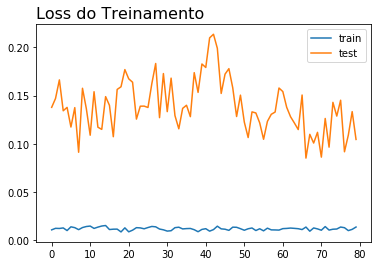

In [34]:
# Hisorico de treinamento
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss do Treinamento', loc='left', fontsize=16)
plt.legend()

Usando o modelo para predição dos dados de **Teste (dois últimos meses)**. Após predição, inverte a normalização dos dados para voltar ao valor original

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

# invert predictions
trainPredict  = scaler.inverse_transform(trainPredict)
rtrainY       = scaler.inverse_transform([trainY])
testPredict   = scaler.inverse_transform(testPredict)
rtestY        = scaler.inverse_transform([testY])

In [39]:
#testX

Calcula o ***RMSE*** dos dados de treinamento e teste

In [40]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(rtrainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(rtestY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 110.16 RMSE
Test Score: 563.93 RMSE


### 3. Utilização do Modelo para previsão do valor

In [41]:
predictDates  = df.tail(len(trainX)).index
actual_chart  = go.Scatter(x=predictDates, y=rtrainY[0], name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=trainPredict[:,0], name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

#### Previsão dos últimos 1 meses

In [42]:
predictDates  = df.tail(len(testX)).index

actual_chart  = go.Scatter(x=predictDates, y=rtestY[0], name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=testPredict[:,0], name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

## + Links

* https://matheusfacure.github.io/2017/02/16/rnn-poesia/
* https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714
* https://www.youtube.com/watch?v=UNmqTiOnRfg&t=646s